# Models Comparison for TinyML

In [22]:
# Load libraries
import numpy as np
from numpy import arange
import pickle

#
import matplotlib.pyplot as plt

#
import pandas as pd
from pandas import read_csv

from sklearn.metrics import confusion_matrix,  classification_report, f1_score
from sklearn.model_selection import train_test_split, KFold,StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler

from keras.models import Sequential, Model 
from keras.layers import Dense, Input, concatenate, Activation, Dropout
from keras.optimizers import Adam
from tensorflow.keras import layers

import tensorflow
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from micromlgen import port
import tinymlgen as tiny

import warnings
import sys
import seaborn as sbs

warnings.filterwarnings('ignore')

In [23]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tensorflow.random.set_seed(RANDOM_SEED)
np.set_printoptions(threshold=sys.maxsize)

## Change 'chosenIndex' to change the chosen Test (s/s3/s6)

In [64]:
dataXPath = ['../data/X.pkl', '../data/XS3.pkl', '../data/XS6.pkl']
dataYPath = ['../data/y.pkl', '../data/yS3.pkl', '../data/yS6.pkl']
choosenIndex = 2

with open(dataXPath[choosenIndex], 'rb') as f:
    X = pickle.load(f)

with open(dataYPath[choosenIndex], 'rb') as f:
    y = pickle.load(f)

In [65]:
print(np.unique(y))

[2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000]


In [66]:
# Convert the labels in values like 0...n for the NN tests

labels = []
uniques = list(np.unique(y))

[labels.append(uniques.index(el)) for el in y]

y = np.array(labels)
print(y)

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)

In [68]:
print(y_test.shape)

(220,)


## Model Spotting

In [52]:
# Test options and evaluation metric
num_folds = 10
seed = 42
scoring = 'f1_macro'


In [53]:
# Spot-Check Algorithms
models = []

#models.append(('XGB', XGBClassifier(random_state=seed)))
models.append(('GNB', GaussianNB(var_smoothing=2e-9)))
models.append(('LR', Pipeline([('Scaler', StandardScaler()),('LR', LogisticRegression(random_state=seed))])))
models.append(('CART' , DecisionTreeClassifier(random_state=seed)))
models.append(('SVC' , Pipeline([('Scaler', StandardScaler()), ('SVC', SVC(gamma=0.05, random_state=seed))])))
models.append(('RF', RandomForestClassifier(random_state=seed, n_estimators = 50)))


In [54]:
results = []
names = []
for name, model in models:
    # Dividere dati in n = num_folds
    kf = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = np.array([])
    for train_idx, test_idx, in kf.split(X_train, y_train):
        X_cross_train, y_cross_train = X_train[train_idx], y_train[train_idx]
        X_cross_test, y_cross_test = X_train[test_idx], y_train[test_idx]
        model.fit(X_cross_train, y_cross_train)  
        y_pred = model.predict(X_cross_test)
        f1s = f1_score(y_cross_test, y_pred, average="weighted")
        cv_results = np.append(cv_results, [f1s])
    results.append(cv_results)
    names.append(name)
    #msg = "%s - %f - %f" % (name, cv_results.mean(), cv_results.std())
    msg = "{} - {:.2f} {:.2f}".format(name, cv_results.mean(), cv_results.std()).replace('.', ',')
    print(msg)

GNB - 0,53 0,04
LR - 0,49 0,06
CART - 0,55 0,05
SVC - 0,47 0,05
RF - 0,64 0,04


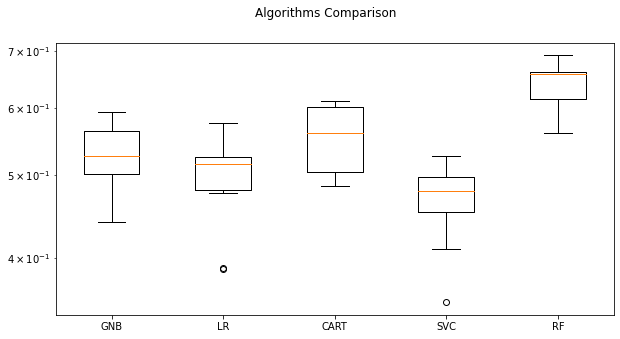

In [55]:
# Compare Algorithms
fig = plt.figure(figsize=(10,5))
fig.suptitle('Algorithms Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_yscale('log')
ax.set_xticklabels(names)
plt.show()

# Valutazione dei modelli sul Test Set

In [56]:
tasks = ['S', 'S3', 'S6']
def classification_report_csv(report, model_name):
    report_data = []
    lines = report.split('\n')
    index = 0
    row = lines[-4].split('    ')
    accuracy = row[-2]
    for line in lines[2:-5]:
        row = {}
        row_data = line.split('      ')
        row['class'] = uniques[index]
        row['precision'] = float(row_data[2]) 
        row['recall'] = float(row_data[3]) 
        row['f1_score'] = float(row_data[4])
        row['accuracy'] = accuracy
        report_data.append(row)
        index += 1
    dataframe = pd.DataFrame.from_dict(report_data)
    dataframe.to_csv(tasks[choosenIndex]+ '/'+'classification_report' + model_name +  '.csv', index = False)
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
for name, model in models:
    model.fit(X_train,  y_train)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    print(f"Model {name}: ")
    report = classification_report(y_test, pred_test)
    print(report)
    classification_report_csv(report, name)
    print("-------------------------------------------------------------")

Model GNB: 
              precision    recall  f1-score   support

           0       0.74      1.00      0.85        20
           1       1.00      0.90      0.95        20
           2       0.18      0.10      0.13        20
           3       0.88      0.70      0.78        20
           4       0.37      0.50      0.43        20
           5       0.00      0.00      0.00        20
           6       0.79      0.95      0.86        20
           7       0.47      0.70      0.56        20
           8       0.54      0.70      0.61        20
           9       0.40      0.20      0.27        20
          10       0.50      0.75      0.60        20

    accuracy                           0.59       220
   macro avg       0.53      0.59      0.55       220
weighted avg       0.53      0.59      0.55       220

-------------------------------------------------------------
Model LR: 
              precision    recall  f1-score   support

           0       0.58      0.35      0.44    

# Valutazione Inferance Rate medio (|X_test| = 50/50/100)

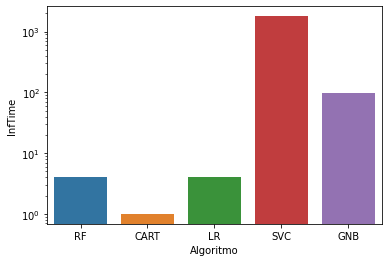

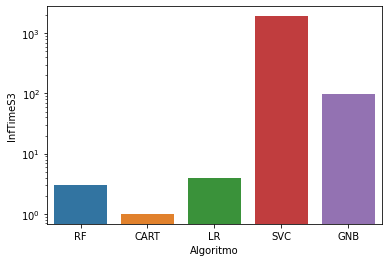

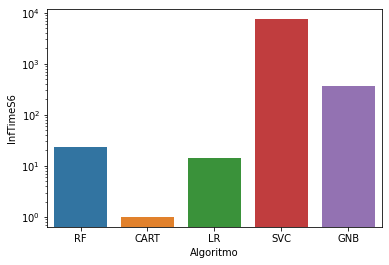

In [57]:
columns = ['InfTime', 'InfTimeS3', 'InfTimeS6']
for c in columns:
    csv = read_csv("InfTimeReport.csv")
    g = sbs.barplot(x=csv['Algoritmo'], y=csv[c])
    g.set_yscale("log")
    plt.ylabel(c)
    plt.show()


# Memoria occupata

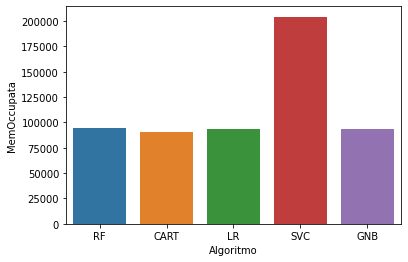

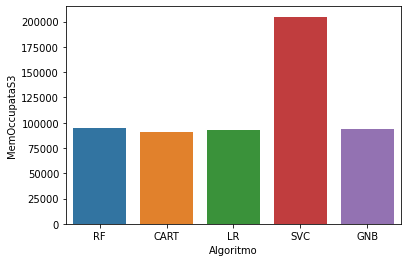

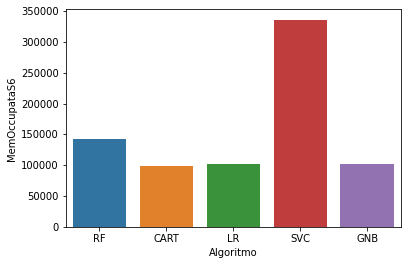

In [58]:
columns = ['MemOccupata', 'MemOccupataS3', 'MemOccupataS6']
for c in columns:   
    csv = read_csv("MemOccupationReport.csv")
    g = sbs.barplot(x=csv['Algoritmo'], y=csv[c])
    plt.ylabel(c)
    plt.show()

# Neural Network

In [59]:
def getNetwork(): 
    n = 100
    model = Sequential(name="Sequential-NN")
    model.add(layers.Dense(X.shape[1], activation='relu', input_shape=(X.shape[1],)))
    model.add(layers.Dense(np.unique(y).size * n, activation='relu'))
    model.add(layers.Dense(np.unique(y).size, activation='softmax'))
    opt = Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

# Cross-Validation NN

In [27]:
EPOCHS = 500
BATCH_SIZE = 8
num_folds = 10


kf = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
cv_results = np.array([])
for train_idx, test_idx, in kf.split(X_train, y_train):
    X_cross_train, y_cross_train = X_train[train_idx], y_train[train_idx]
    X_cross_train = scaler.fit_transform(X_cross_train)
    X_cross_test, y_cross_test = X_train[test_idx], y_train[test_idx]
    X_cross_test = scaler.transform(X_cross_test)
    model = getNetwork()
    model.fit(X_cross_train, y_cross_train, epochs=EPOCHS, batch_size=BATCH_SIZE)  
    y_pred = model.predict(X_cross_test)
    predictions_categorical = np.argmax(y_pred, axis=1)
    f1s = f1_score(y_cross_test, predictions_categorical, average="weighted")
    cv_results = np.append(cv_results, [f1s])

print(f'Average score of Cross Validation: {cv_results.mean()}')

Model: "Sequential-NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_7 (Dense)              (None, 600)               19800     
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 3606      
Total params: 24,462
Trainable params: 24,462
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
54/54 [==============================] - 0s 540us/step - loss: 1.2375 - accuracy: 0.3796
Epoch 2/500
54/54 [==============================] - 0s 565us/step - loss: 0.9130 - accuracy: 0.5069
Epoch 3/500
54/54 [==============================] - 0s 543us/step - loss: 0.6900 - accuracy: 0.6829
Epoch 4/500
54/54 [==============================] - 0s 528us/step - loss: 0

54/54 [==============================] - 0s 584us/step - loss: 0.1773 - accuracy: 0.8843
Epoch 75/500
54/54 [==============================] - 0s 574us/step - loss: 0.1791 - accuracy: 0.8727
Epoch 76/500
54/54 [==============================] - 0s 563us/step - loss: 0.1725 - accuracy: 0.9074
Epoch 77/500
54/54 [==============================] - 0s 557us/step - loss: 0.1852 - accuracy: 0.8935
Epoch 78/500
54/54 [==============================] - 0s 538us/step - loss: 0.1737 - accuracy: 0.8958
Epoch 79/500
54/54 [==============================] - 0s 538us/step - loss: 0.1761 - accuracy: 0.8935
Epoch 80/500
54/54 [==============================] - 0s 595us/step - loss: 0.1801 - accuracy: 0.8958
Epoch 81/500
54/54 [==============================] - 0s 561us/step - loss: 0.1775 - accuracy: 0.8912
Epoch 82/500
54/54 [==============================] - 0s 568us/step - loss: 0.1730 - accuracy: 0.9167
Epoch 83/500
54/54 [==============================] - 0s 582us/step - loss: 0.1712 - accuracy: 

KeyboardInterrupt: 

# Train and Test

In [60]:
EPOCHS = 500 if choosenIndex == 0 else 1000
BATCH_SIZE = 8

model = getNetwork()
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.25)
pred = model.predict(X_test)
pred = np.argmax(pred, axis=1)
report = classification_report(y_test, pred)
classification_report_csv(report, "NN")
print(report)

Model: "Sequential-NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_7 (Dense)              (None, 1100)              36300     
_________________________________________________________________
dense_8 (Dense)              (None, 11)                12111     
Total params: 49,467
Trainable params: 49,467
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
83/83 [==============================] - 0s 1ms/step - loss: 1.8209 - accuracy: 0.2227 - val_loss: 1.6424 - val_accuracy: 0.2500
Epoch 2/1000
83/83 [==============================] - 0s 631us/step - loss: 1.4755 - accuracy: 0.3727 - val_loss: 1.3442 - val_accuracy: 0.4500
Epoch 3/1000
83/83 [==============================] - 0s 619us/step - loss: 1.2806 - accuracy

83/83 [==============================] - 0s 647us/step - loss: 0.8372 - accuracy: 0.6485 - val_loss: 1.0991 - val_accuracy: 0.5773
Epoch 53/1000
83/83 [==============================] - 0s 631us/step - loss: 0.8261 - accuracy: 0.6530 - val_loss: 1.0718 - val_accuracy: 0.5636
Epoch 54/1000
83/83 [==============================] - 0s 636us/step - loss: 0.8391 - accuracy: 0.6455 - val_loss: 1.1462 - val_accuracy: 0.5682
Epoch 55/1000
83/83 [==============================] - 0s 651us/step - loss: 0.8282 - accuracy: 0.6561 - val_loss: 1.1305 - val_accuracy: 0.5000
Epoch 56/1000
83/83 [==============================] - 0s 636us/step - loss: 0.8249 - accuracy: 0.6394 - val_loss: 1.0782 - val_accuracy: 0.6318
Epoch 57/1000
83/83 [==============================] - 0s 641us/step - loss: 0.8387 - accuracy: 0.6182 - val_loss: 1.1406 - val_accuracy: 0.5091
Epoch 58/1000
83/83 [==============================] - 0s 613us/step - loss: 0.7974 - accuracy: 0.6742 - val_loss: 1.0794 - val_accuracy: 0.5136

83/83 [==============================] - 0s 655us/step - loss: 0.5439 - accuracy: 0.7894 - val_loss: 1.3436 - val_accuracy: 0.5773
Epoch 109/1000
83/83 [==============================] - 0s 651us/step - loss: 0.5505 - accuracy: 0.7848 - val_loss: 1.3306 - val_accuracy: 0.6091
Epoch 110/1000
83/83 [==============================] - 0s 670us/step - loss: 0.5958 - accuracy: 0.7439 - val_loss: 1.4485 - val_accuracy: 0.5318
Epoch 111/1000
83/83 [==============================] - 0s 638us/step - loss: 0.5578 - accuracy: 0.7727 - val_loss: 1.3807 - val_accuracy: 0.6182
Epoch 112/1000
83/83 [==============================] - 0s 624us/step - loss: 0.5454 - accuracy: 0.7924 - val_loss: 1.3201 - val_accuracy: 0.6273
Epoch 113/1000
83/83 [==============================] - 0s 630us/step - loss: 0.5354 - accuracy: 0.7818 - val_loss: 1.3362 - val_accuracy: 0.5727
Epoch 114/1000
83/83 [==============================] - 0s 652us/step - loss: 0.5514 - accuracy: 0.7727 - val_loss: 1.3901 - val_accuracy: 

83/83 [==============================] - 0s 651us/step - loss: 0.4156 - accuracy: 0.8379 - val_loss: 1.6851 - val_accuracy: 0.6545
Epoch 165/1000
83/83 [==============================] - 0s 665us/step - loss: 0.3878 - accuracy: 0.8379 - val_loss: 1.6760 - val_accuracy: 0.6545
Epoch 166/1000
83/83 [==============================] - 0s 640us/step - loss: 0.3743 - accuracy: 0.8636 - val_loss: 1.6744 - val_accuracy: 0.6318
Epoch 167/1000
83/83 [==============================] - 0s 655us/step - loss: 0.3395 - accuracy: 0.8758 - val_loss: 1.7696 - val_accuracy: 0.5773
Epoch 168/1000
83/83 [==============================] - 0s 655us/step - loss: 0.3916 - accuracy: 0.8485 - val_loss: 1.7539 - val_accuracy: 0.6500
Epoch 169/1000
83/83 [==============================] - 0s 638us/step - loss: 0.3985 - accuracy: 0.8318 - val_loss: 1.9246 - val_accuracy: 0.5455
Epoch 170/1000
83/83 [==============================] - 0s 642us/step - loss: 0.4128 - accuracy: 0.8348 - val_loss: 1.6707 - val_accuracy: 

83/83 [==============================] - 0s 607us/step - loss: 0.3357 - accuracy: 0.8621 - val_loss: 2.0685 - val_accuracy: 0.6545
Epoch 221/1000
83/83 [==============================] - 0s 629us/step - loss: 0.3268 - accuracy: 0.8697 - val_loss: 2.1842 - val_accuracy: 0.6682
Epoch 222/1000
83/83 [==============================] - 0s 627us/step - loss: 0.3014 - accuracy: 0.8803 - val_loss: 2.0934 - val_accuracy: 0.6818
Epoch 223/1000
83/83 [==============================] - 0s 635us/step - loss: 0.3012 - accuracy: 0.8955 - val_loss: 2.2225 - val_accuracy: 0.6409
Epoch 224/1000
83/83 [==============================] - 0s 633us/step - loss: 0.3002 - accuracy: 0.8848 - val_loss: 2.3331 - val_accuracy: 0.6273
Epoch 225/1000
83/83 [==============================] - 0s 614us/step - loss: 0.2967 - accuracy: 0.8773 - val_loss: 2.3282 - val_accuracy: 0.5682
Epoch 226/1000
83/83 [==============================] - 0s 627us/step - loss: 0.3328 - accuracy: 0.8636 - val_loss: 2.1176 - val_accuracy: 

83/83 [==============================] - 0s 633us/step - loss: 0.2572 - accuracy: 0.8985 - val_loss: 2.6944 - val_accuracy: 0.6545
Epoch 277/1000
83/83 [==============================] - 0s 640us/step - loss: 0.3261 - accuracy: 0.8773 - val_loss: 2.5783 - val_accuracy: 0.6364
Epoch 278/1000
83/83 [==============================] - 0s 621us/step - loss: 0.2411 - accuracy: 0.9106 - val_loss: 2.6067 - val_accuracy: 0.6409
Epoch 279/1000
83/83 [==============================] - 0s 634us/step - loss: 0.2897 - accuracy: 0.8909 - val_loss: 2.4559 - val_accuracy: 0.6682
Epoch 280/1000
83/83 [==============================] - 0s 630us/step - loss: 0.2901 - accuracy: 0.8924 - val_loss: 2.7018 - val_accuracy: 0.6136
Epoch 281/1000
83/83 [==============================] - 0s 622us/step - loss: 0.2833 - accuracy: 0.8727 - val_loss: 2.4432 - val_accuracy: 0.6636
Epoch 282/1000
83/83 [==============================] - 0s 648us/step - loss: 0.3274 - accuracy: 0.8667 - val_loss: 2.6400 - val_accuracy: 

83/83 [==============================] - 0s 606us/step - loss: 0.2263 - accuracy: 0.9197 - val_loss: 2.9298 - val_accuracy: 0.6545
Epoch 333/1000
83/83 [==============================] - 0s 635us/step - loss: 0.2088 - accuracy: 0.9212 - val_loss: 2.8428 - val_accuracy: 0.6773
Epoch 334/1000
83/83 [==============================] - 0s 619us/step - loss: 0.2188 - accuracy: 0.9136 - val_loss: 3.0408 - val_accuracy: 0.6045
Epoch 335/1000
83/83 [==============================] - 0s 636us/step - loss: 0.2954 - accuracy: 0.8727 - val_loss: 2.7717 - val_accuracy: 0.6545
Epoch 336/1000
83/83 [==============================] - 0s 612us/step - loss: 0.3127 - accuracy: 0.8803 - val_loss: 2.7999 - val_accuracy: 0.6409
Epoch 337/1000
83/83 [==============================] - 0s 622us/step - loss: 0.1987 - accuracy: 0.9333 - val_loss: 2.7529 - val_accuracy: 0.6909
Epoch 338/1000
83/83 [==============================] - 0s 608us/step - loss: 0.1726 - accuracy: 0.9409 - val_loss: 3.1118 - val_accuracy: 

83/83 [==============================] - 0s 620us/step - loss: 0.2027 - accuracy: 0.9121 - val_loss: 3.2252 - val_accuracy: 0.6455
Epoch 389/1000
83/83 [==============================] - 0s 634us/step - loss: 0.1997 - accuracy: 0.9242 - val_loss: 3.0099 - val_accuracy: 0.6818
Epoch 390/1000
83/83 [==============================] - 0s 622us/step - loss: 0.1701 - accuracy: 0.9288 - val_loss: 3.0651 - val_accuracy: 0.6091
Epoch 391/1000
83/83 [==============================] - 0s 610us/step - loss: 0.1717 - accuracy: 0.9318 - val_loss: 3.1187 - val_accuracy: 0.6682
Epoch 392/1000
83/83 [==============================] - 0s 607us/step - loss: 0.1312 - accuracy: 0.9576 - val_loss: 3.2179 - val_accuracy: 0.6409
Epoch 393/1000
83/83 [==============================] - 0s 644us/step - loss: 0.1620 - accuracy: 0.9364 - val_loss: 3.1119 - val_accuracy: 0.6818
Epoch 394/1000
83/83 [==============================] - 0s 618us/step - loss: 0.1551 - accuracy: 0.9394 - val_loss: 3.2190 - val_accuracy: 

83/83 [==============================] - 0s 759us/step - loss: 0.2664 - accuracy: 0.8985 - val_loss: 3.7788 - val_accuracy: 0.5955
Epoch 445/1000
83/83 [==============================] - 0s 633us/step - loss: 0.5136 - accuracy: 0.8409 - val_loss: 3.1541 - val_accuracy: 0.6636
Epoch 446/1000
83/83 [==============================] - 0s 647us/step - loss: 0.1663 - accuracy: 0.9485 - val_loss: 3.0709 - val_accuracy: 0.6773
Epoch 447/1000
83/83 [==============================] - 0s 640us/step - loss: 0.1469 - accuracy: 0.9439 - val_loss: 3.0088 - val_accuracy: 0.6682
Epoch 448/1000
83/83 [==============================] - 0s 638us/step - loss: 0.1114 - accuracy: 0.9606 - val_loss: 3.0503 - val_accuracy: 0.6909
Epoch 449/1000
83/83 [==============================] - 0s 655us/step - loss: 0.1467 - accuracy: 0.9439 - val_loss: 3.2140 - val_accuracy: 0.6636
Epoch 450/1000
83/83 [==============================] - 0s 636us/step - loss: 0.1107 - accuracy: 0.9606 - val_loss: 3.1187 - val_accuracy: 

83/83 [==============================] - 0s 808us/step - loss: 0.1349 - accuracy: 0.9409 - val_loss: 3.6023 - val_accuracy: 0.6636
Epoch 501/1000
83/83 [==============================] - 0s 641us/step - loss: 0.1168 - accuracy: 0.9485 - val_loss: 3.4785 - val_accuracy: 0.6591
Epoch 502/1000
83/83 [==============================] - 0s 627us/step - loss: 0.1392 - accuracy: 0.9500 - val_loss: 3.3800 - val_accuracy: 0.6955
Epoch 503/1000
83/83 [==============================] - 0s 642us/step - loss: 0.1162 - accuracy: 0.9530 - val_loss: 3.2744 - val_accuracy: 0.6455
Epoch 504/1000
83/83 [==============================] - 0s 643us/step - loss: 0.1229 - accuracy: 0.9515 - val_loss: 3.4213 - val_accuracy: 0.6955
Epoch 505/1000
83/83 [==============================] - 0s 644us/step - loss: 0.1260 - accuracy: 0.9530 - val_loss: 3.5796 - val_accuracy: 0.6545
Epoch 506/1000
83/83 [==============================] - 0s 659us/step - loss: 0.4053 - accuracy: 0.8409 - val_loss: 3.5193 - val_accuracy: 

83/83 [==============================] - 0s 618us/step - loss: 0.1190 - accuracy: 0.9515 - val_loss: 3.6143 - val_accuracy: 0.6818
Epoch 557/1000
83/83 [==============================] - 0s 621us/step - loss: 0.1635 - accuracy: 0.9364 - val_loss: 3.5916 - val_accuracy: 0.6636
Epoch 558/1000
83/83 [==============================] - 0s 615us/step - loss: 0.1557 - accuracy: 0.9348 - val_loss: 3.6582 - val_accuracy: 0.6682
Epoch 559/1000
83/83 [==============================] - 0s 629us/step - loss: 0.0948 - accuracy: 0.9667 - val_loss: 3.5302 - val_accuracy: 0.6773
Epoch 560/1000
83/83 [==============================] - 0s 627us/step - loss: 0.1191 - accuracy: 0.9545 - val_loss: 3.7262 - val_accuracy: 0.6682
Epoch 561/1000
83/83 [==============================] - 0s 610us/step - loss: 0.0715 - accuracy: 0.9758 - val_loss: 3.5780 - val_accuracy: 0.6727
Epoch 562/1000
83/83 [==============================] - 0s 627us/step - loss: 0.0946 - accuracy: 0.9682 - val_loss: 3.7230 - val_accuracy: 

83/83 [==============================] - 0s 637us/step - loss: 0.0819 - accuracy: 0.9682 - val_loss: 3.6520 - val_accuracy: 0.6864
Epoch 613/1000
83/83 [==============================] - 0s 688us/step - loss: 0.0645 - accuracy: 0.9742 - val_loss: 3.7970 - val_accuracy: 0.6636
Epoch 614/1000
83/83 [==============================] - 0s 651us/step - loss: 0.2027 - accuracy: 0.9167 - val_loss: 3.7899 - val_accuracy: 0.6455
Epoch 615/1000
83/83 [==============================] - 0s 691us/step - loss: 0.1700 - accuracy: 0.9333 - val_loss: 3.9226 - val_accuracy: 0.6227
Epoch 616/1000
83/83 [==============================] - 0s 673us/step - loss: 0.2317 - accuracy: 0.9106 - val_loss: 3.7391 - val_accuracy: 0.6818
Epoch 617/1000
83/83 [==============================] - 0s 651us/step - loss: 0.1216 - accuracy: 0.9515 - val_loss: 3.6196 - val_accuracy: 0.6636
Epoch 618/1000
83/83 [==============================] - 0s 632us/step - loss: 0.0791 - accuracy: 0.9712 - val_loss: 3.7382 - val_accuracy: 

83/83 [==============================] - 0s 650us/step - loss: 0.0583 - accuracy: 0.9773 - val_loss: 3.9124 - val_accuracy: 0.6500
Epoch 669/1000
83/83 [==============================] - 0s 651us/step - loss: 0.1150 - accuracy: 0.9530 - val_loss: 4.1154 - val_accuracy: 0.6318
Epoch 670/1000
83/83 [==============================] - 0s 645us/step - loss: 0.1602 - accuracy: 0.9333 - val_loss: 3.9315 - val_accuracy: 0.6636
Epoch 671/1000
83/83 [==============================] - 0s 633us/step - loss: 0.0827 - accuracy: 0.9636 - val_loss: 3.8357 - val_accuracy: 0.6591
Epoch 672/1000
83/83 [==============================] - 0s 660us/step - loss: 0.0782 - accuracy: 0.9758 - val_loss: 4.0167 - val_accuracy: 0.6318
Epoch 673/1000
83/83 [==============================] - 0s 660us/step - loss: 0.0802 - accuracy: 0.9727 - val_loss: 3.9842 - val_accuracy: 0.6273
Epoch 674/1000
83/83 [==============================] - 0s 653us/step - loss: 0.0904 - accuracy: 0.9697 - val_loss: 4.1780 - val_accuracy: 

83/83 [==============================] - 0s 679us/step - loss: 0.1409 - accuracy: 0.9455 - val_loss: 4.0851 - val_accuracy: 0.6318
Epoch 725/1000
83/83 [==============================] - 0s 663us/step - loss: 0.0912 - accuracy: 0.9712 - val_loss: 3.8803 - val_accuracy: 0.6545
Epoch 726/1000
83/83 [==============================] - 0s 618us/step - loss: 0.0992 - accuracy: 0.9606 - val_loss: 4.0809 - val_accuracy: 0.6455
Epoch 727/1000
83/83 [==============================] - 0s 642us/step - loss: 0.0645 - accuracy: 0.9788 - val_loss: 3.9814 - val_accuracy: 0.6727
Epoch 728/1000
83/83 [==============================] - 0s 633us/step - loss: 0.1332 - accuracy: 0.9500 - val_loss: 4.4161 - val_accuracy: 0.6091
Epoch 729/1000
83/83 [==============================] - 0s 660us/step - loss: 0.1169 - accuracy: 0.9606 - val_loss: 4.1958 - val_accuracy: 0.6727
Epoch 730/1000
83/83 [==============================] - 0s 677us/step - loss: 0.0679 - accuracy: 0.9758 - val_loss: 4.1278 - val_accuracy: 

83/83 [==============================] - 0s 658us/step - loss: 0.1084 - accuracy: 0.9530 - val_loss: 4.1280 - val_accuracy: 0.6227
Epoch 781/1000
83/83 [==============================] - 0s 672us/step - loss: 0.1275 - accuracy: 0.9515 - val_loss: 4.0678 - val_accuracy: 0.5773
Epoch 782/1000
83/83 [==============================] - 0s 651us/step - loss: 0.0949 - accuracy: 0.9682 - val_loss: 4.0546 - val_accuracy: 0.5955
Epoch 783/1000
83/83 [==============================] - 0s 629us/step - loss: 0.1147 - accuracy: 0.9515 - val_loss: 4.1728 - val_accuracy: 0.6227
Epoch 784/1000
83/83 [==============================] - 0s 648us/step - loss: 0.1087 - accuracy: 0.9576 - val_loss: 4.1522 - val_accuracy: 0.6500
Epoch 785/1000
83/83 [==============================] - 0s 617us/step - loss: 0.1103 - accuracy: 0.9636 - val_loss: 3.8462 - val_accuracy: 0.6591
Epoch 786/1000
83/83 [==============================] - 0s 640us/step - loss: 0.1153 - accuracy: 0.9652 - val_loss: 3.9072 - val_accuracy: 

83/83 [==============================] - 0s 676us/step - loss: 0.1970 - accuracy: 0.9303 - val_loss: 4.3555 - val_accuracy: 0.6682
Epoch 837/1000
83/83 [==============================] - 0s 658us/step - loss: 0.0700 - accuracy: 0.9788 - val_loss: 4.3985 - val_accuracy: 0.6364
Epoch 838/1000
83/83 [==============================] - 0s 645us/step - loss: 0.0760 - accuracy: 0.9667 - val_loss: 4.2215 - val_accuracy: 0.6591
Epoch 839/1000
83/83 [==============================] - 0s 662us/step - loss: 0.0487 - accuracy: 0.9879 - val_loss: 4.2785 - val_accuracy: 0.6545
Epoch 840/1000
83/83 [==============================] - 0s 659us/step - loss: 0.0373 - accuracy: 0.9894 - val_loss: 4.2851 - val_accuracy: 0.6864
Epoch 841/1000
83/83 [==============================] - 0s 677us/step - loss: 0.0549 - accuracy: 0.9773 - val_loss: 4.4076 - val_accuracy: 0.6455
Epoch 842/1000
83/83 [==============================] - 0s 642us/step - loss: 0.0798 - accuracy: 0.9667 - val_loss: 4.4246 - val_accuracy: 

83/83 [==============================] - 0s 675us/step - loss: 0.0661 - accuracy: 0.9803 - val_loss: 4.1387 - val_accuracy: 0.6773
Epoch 893/1000
83/83 [==============================] - 0s 831us/step - loss: 0.0573 - accuracy: 0.9773 - val_loss: 4.0735 - val_accuracy: 0.6864
Epoch 894/1000
83/83 [==============================] - 0s 718us/step - loss: 0.0330 - accuracy: 0.9894 - val_loss: 4.1520 - val_accuracy: 0.6773
Epoch 895/1000
83/83 [==============================] - 0s 731us/step - loss: 0.0457 - accuracy: 0.9818 - val_loss: 4.2894 - val_accuracy: 0.6545
Epoch 896/1000
83/83 [==============================] - 0s 709us/step - loss: 0.0532 - accuracy: 0.9803 - val_loss: 4.2488 - val_accuracy: 0.6773
Epoch 897/1000
83/83 [==============================] - 0s 684us/step - loss: 0.0503 - accuracy: 0.9848 - val_loss: 4.2170 - val_accuracy: 0.6500
Epoch 898/1000
83/83 [==============================] - 0s 680us/step - loss: 0.0655 - accuracy: 0.9742 - val_loss: 4.4348 - val_accuracy: 

83/83 [==============================] - 0s 656us/step - loss: 0.0499 - accuracy: 0.9803 - val_loss: 4.5412 - val_accuracy: 0.6273
Epoch 949/1000
83/83 [==============================] - 0s 624us/step - loss: 0.0894 - accuracy: 0.9576 - val_loss: 4.2670 - val_accuracy: 0.6364
Epoch 950/1000
83/83 [==============================] - 0s 632us/step - loss: 0.0631 - accuracy: 0.9773 - val_loss: 4.3202 - val_accuracy: 0.6545
Epoch 951/1000
83/83 [==============================] - 0s 624us/step - loss: 0.0451 - accuracy: 0.9848 - val_loss: 4.2052 - val_accuracy: 0.6773
Epoch 952/1000
83/83 [==============================] - 0s 628us/step - loss: 0.0343 - accuracy: 0.9894 - val_loss: 4.1834 - val_accuracy: 0.6773
Epoch 953/1000
83/83 [==============================] - 0s 625us/step - loss: 0.0483 - accuracy: 0.9833 - val_loss: 4.1551 - val_accuracy: 0.6636
Epoch 954/1000
83/83 [==============================] - 0s 702us/step - loss: 0.0626 - accuracy: 0.9758 - val_loss: 4.2047 - val_accuracy: 

# Export Models in C code

In [61]:
# Models in Pipeline
modelsInPipeline = []
modelsInPipeline.append('LR')
modelsInPipeline.append('SVC')

In [62]:
directories = ['s/', 's3/', 's6/']

# Neural network with TinyMLGen
with open('exportedModels/' + directories[choosenIndex] + 'NNmodel.h', 'w') as f:
    f.write(tiny.port(model, optimize=False))

# Classifiers with MicroMLGen
for name, model in models:
    prepath = 'exportedModels/' + directories[choosenIndex]
    path = prepath + name + '.h'
    if name in modelsInPipeline:
        model = model[1]
    with open(path, 'w') as f:
        f.write(port(model, optimize=True))

INFO:tensorflow:Assets written to: /tmp/tmptzodjen8/assets


INFO:tensorflow:Assets written to: /tmp/tmptzodjen8/assets
